In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import PIL
import json
from urbanComponent import *
import math
from vedo import download, Points, Axes, show

from persim import plot_diagrams
from ripser import ripser, lower_star_img

c:\Users\Gustavo\anaconda3\envs\urbantk\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
f = open('../../../public/data/manhattan_wo_cells/buildings_s_joined.json', 'r')

data = json.load(f)

joinedLayerIndex = 0

values = []

for joinedObject in data['joinedObjects']:
    if(joinedObject['joinedLayerIndex'] == joinedLayerIndex):
        values = joinedObject['inValues']
        break

f.close()

uc = UrbanComponent()

uc.setWorkDir("../../../public/data/manhattan_wo_cells")
uc.addLayerFromJsonFile("../../../public/data/manhattan_wo_cells/buildings_s.json")

buildingsJson = uc.layers['json'][0]

# f = open('./buildings.json', 'w')

# f.write(json.dumps(buildingsJson))

# f.close()

latitude = []
longitude = []
height = []

for geometry in buildingsJson['data']:
    for i in range(int(len(geometry['geometry']['coordinates'])/3)):
        latitude.append(geometry['geometry']['coordinates'][i*3])
        longitude.append(geometry['geometry']['coordinates'][i*3+1])
        height.append(geometry['geometry']['coordinates'][i*3+2])

df = pd.DataFrame(data={'latitude': latitude, 'longitude': longitude, 'height': height})

m1 = df[['latitude','longitude','height']].to_numpy()[:,1]
m2 = df[['latitude','longitude','height']].to_numpy()[:,0]
m3 = df[['latitude','longitude','height']].to_numpy()[:,2]

xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
zmin = m3.min()
zmax = m3.max()

values = np.array(values).reshape((len(values),))

wmin = values.min()
wmax = values.max()

# X, Y, Z, W = np.mgrid[xmin:xmax:100, ymin:ymax:100, zmin:zmax:50, wmin:wmax:0.1]

# X, Y, Z = np.mgrid[xmin:xmax:100, ymin:ymax:100, zmin:zmax:50]
X, Y, Z = np.mgrid[xmin:xmax:25, ymin:ymax:25, zmin:zmax:50]

# positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()]) # grid positions

positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]) # grid positions

# data_points = np.vstack([m1, m2, m3, values]) 

data_points = np.vstack([m1, m2, m3]) 

kernel = scipy.stats.gaussian_kde(data_points, weights=values)

mask = positions[2,:] == 50 # getting one slice of the data
positions = positions[:, mask]

# sampled_values = np.reshape(kernel(positions).T, X.shape)
sampled_values = kernel(positions).T
# sampled_values = kernel(positions).T


In [3]:
reshape_sampled_values = np.reshape(sampled_values, (64, 64))

reshape_sampled_values = ((reshape_sampled_values - reshape_sampled_values.min())/(reshape_sampled_values.max() - reshape_sampled_values.min())) # normalizing the data

reshape_sampled_values = reshape_sampled_values * 255

In [4]:
# flat_grid_positions = []

# for i in range(len(positions[0,:])):
#     flat_grid_positions.append(positions[1,i])
#     flat_grid_positions.append(positions[0,i])
#     flat_grid_positions.append(positions[2,i])

# grid_points = {'points': flat_grid_positions, 'values': sampled_values.tolist()}

# json_object = json.dumps(grid_points)

# file = open('grid_points.json', 'w')

# file.write(json_object)

# file.close()

# file = open('grid_values.json', 'w')

# thematic_layer = {
#     "id": "grid_values",
#     "coordinates": flat_grid_positions,
#     "values": sampled_values.tolist()
# }

# file.write(json.dumps(thematic_layer))

# file.close()


### 2D plot

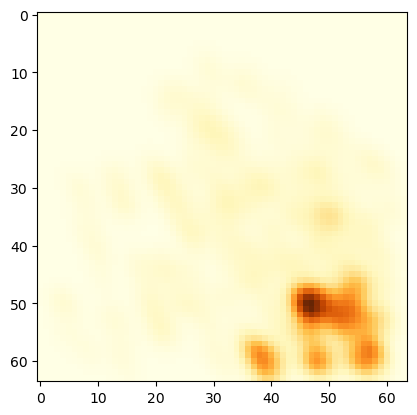

In [5]:
fig, ax = plt.subplots()
ax.imshow(reshape_sampled_values, cmap=plt.cm.YlOrBr)
plt.show()

### Making every pixel to have a unique value

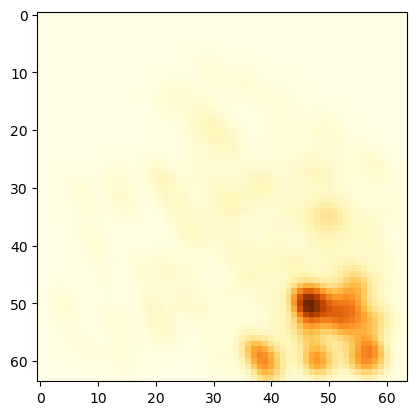

In [6]:
# rand = np.random.randn(*reshape_sampled_values.shape)
# randNorm = ((rand - rand.min())/(rand.max() - rand.min()))*max(reshape_sampled_values.flatten().tolist())
# noisy_result = reshape_sampled_values + (0.1 * randNorm)

noisy_result = reshape_sampled_values + (0.01 * np.random.randn(*reshape_sampled_values.shape))

fig, ax = plt.subplots()
ax.imshow(noisy_result, cmap=plt.cm.YlOrBr)
plt.show()

### Computing persistence diagram

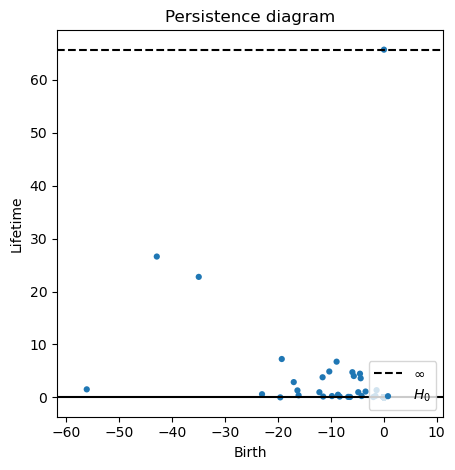

In [7]:
dgm = lower_star_img(noisy_result)
dgm[~np.isinf(dgm)] = -dgm[~np.isinf(dgm)]
dgm[~np.isinf(dgm).any(axis=1)] = np.flip(dgm[~np.isinf(dgm).any(axis=1)])
plot_diagrams(dgm, lifetime=True)
plt.title("Persistence diagram")
plt.tight_layout()
plt.show()

### Selecting points with lifetime greater than the threshold

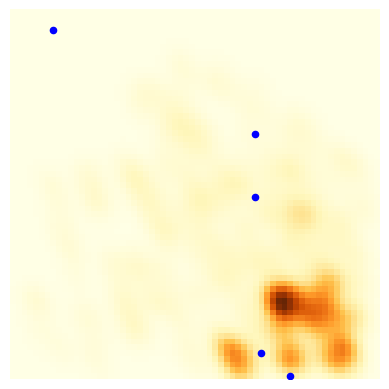

In [8]:
thresh = 5
idxs = np.arange(dgm.shape[0])
idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh]

plt.figure()
plt.imshow(reshape_sampled_values, cmap=plt.cm.YlOrBr)

X, Y = np.meshgrid(np.arange(noisy_result.shape[1]), np.arange(noisy_result.shape[0]))
# X, Y = np.meshgrid(np.arange(reshape_sampled_values.shape[1]), np.arange(reshape_sampled_values.shape[0]))
X = X.flatten()
Y = Y.flatten()

maxima_points = set()

for idx in idxs:
    bidx = np.argmin(np.abs(noisy_result + dgm[idx, 0]))
    maxima_points.add(bidx)
    plt.scatter(X[bidx], Y[bidx], 20, 'blue') # showing each 0-dimensional pixel representatives highlighted in the original image
plt.axis('off')

maxima_points = list(maxima_points)

plt.show()

### Outputting maxima points to file

In [9]:
reshape_positions = np.reshape(positions, (3, 64, 64))

flat_points = []
best_values = []

for point in maxima_points:
    print(Y[point], X[point], reshape_sampled_values[Y[point], X[point]])

    coordinate = reshape_positions[:,Y[point],X[point]]
    flat_points.append(coordinate[1])
    flat_points.append(coordinate[0])
    flat_points.append(coordinate[2])

    best_values.append(reshape_sampled_values[Y[point], X[point]])

best_points = {'points': flat_points, 'values': best_values}

json_object = json.dumps(best_points)

file = open('best_points.json', 'w')

file.write(json_object)

file.close()

file = open('best_values.json', 'w')

thematic_layer = {
    "id": "best_values",
    "coordinates": flat_points,
    "values": best_values
}

file.write(json.dumps(thematic_layer))

file.close()


3 7 2.1424861770912313e-13
32 42 19.272052990832055
59 43 34.95156112699278
21 42 8.910146986094109
63 48 42.88139917161515


### 3D plot

In [10]:
# from vedo import download, Points, Axes, show
# from vedo.pyplot import CornerHistogram

# # pts = np.c_[sampled_values[0,:,:],sampled_values[:,0,:],sampled_values[:,:,0]] # form an array of 3d points from the columns

# # pts = Points(positions[0,:].tolist(), positions[1,:].tolist(), positions[2,:].tolist())
# pts = Points(positions)

# pts.pointdata["scals"] = sampled_values.flatten()

# vol = pts.tovolume(kernel='shepard', N=4, dims=(90,90,90))

# vol.c(["maroon","g","b"])        # set color   transfer function
# vol.alpha([0.3, 0.9])            # set opacity transfer function
# #vol.alpha([(0.3,0.3), (0.9,0.9)]) # alternative way, by specifying (xscalar, alpha)
# # vol.alpha_unit(0.5)              # make the whole object less transparent (default is 1)

# # replace voxels of specific range with a new value
# # vol.threshold(above=0.3, below=0.4, replace=0.9)
# # Note that scalar range now has changed (you may want to reapply vol.c().alpha())

# ch = CornerHistogram(vol, pos="bottom-left")

# # vol.add_scalarbar3d('Height is the voxel scalar', s=[None,1])
# # vol.scalarbar.rotate_x(90).pos(1.15,1,0.5)

# show(pts, vol, ch, __doc__, axes=1, elevation=-90).close()

### Creates points layer from best points

In [11]:
def break_into_binary(filepath, filename, data, types, dataTypes):

    for index, type in enumerate(types):

        readCoords = 0

        floatList = []

        for i in range(len(data['data'])):
            geometry = data['data'][i]['geometry']

            newValue = [readCoords, len(geometry[type])] # where this vector starts and its size

            readCoords += len(geometry[type])

            floatList += geometry[type].copy()

            geometry[type] = newValue

        fout = open(os.path.join(filepath,filename+'_'+type+'.data'), 'wb')

        buf = struct.pack(str(len(floatList))+dataTypes[index], *floatList)

        fout.write(buf)
        fout.close()

        json_object = json.dumps(data)

        with open(os.path.join(filepath,filename+".json"), "w") as outfile:
            outfile.write(json_object)

In [12]:
file = open('best_points.json', 'r')

grid_points = json.load(file)

file.close()

id = 'best_points'
type = 'POINTS_LAYER'
styleKey = 'building'
renderStyle = ['COLOR_POINTS']

layer = {
    'id': id,
    'type': type,
    'styleKey': styleKey,
    'renderStyle': renderStyle
}

layer['data'] = [
    {
        'geometry': {
            'coordinates': grid_points['points']
        }
    }
]

types = []
dataTypes = []

if('coordinates' in layer['data'][0]['geometry']):
    types.append("coordinates")
    dataTypes.append("d")

if('normals' in layer['data'][0]['geometry']):
    types.append("normals")
    dataTypes.append("f")

if('indices' in layer['data'][0]['geometry']):
    types.append("indices")
    dataTypes.append("I")

if('ids' in layer['data'][0]['geometry']):
    types.append("ids")
    dataTypes.append("I")

break_into_binary('./', layer['id'], layer, types, dataTypes)
